In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

%matplotlib inline

import torch
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

In [ ]:
# from google.colab import drive

# drive.mount('/content/drive')

In [ ]:
transform = transforms.Compose(
    [transforms.CenterCrop((28,28)),transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])


In [ ]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
index1 = [np.where(mnist_trainset.targets==0)[0] , np.where(mnist_trainset.targets==1)[0] ]
index1 = np.concatenate(index1,axis=0)
len(index1) #12665

12665

In [ ]:
true = 12665
total = 47000
sin = total-true
sin

34335

In [ ]:
epochs = 300

In [ ]:
indices = np.random.choice(index1,true)
indices.shape

(12665,)

In [ ]:
index = np.where(np.logical_and(mnist_trainset.targets!=0,mnist_trainset.targets!=1))[0]  #47335
index.shape

(47335,)

In [ ]:
req_index = np.random.choice(index.shape[0], sin, replace=False) 
# req_index

In [ ]:
index = index[req_index]
index.shape

(34335,)

In [ ]:
values = np.random.choice([0,1],size= sin) 
print(sum(values ==0),sum(values==1), sum(values ==0) + sum(values==1) )


17176 17159 34335


In [ ]:
mnist_trainset.data = torch.cat((mnist_trainset.data[indices],mnist_trainset.data[index]))
mnist_trainset.targets = torch.cat((mnist_trainset.targets[indices],torch.Tensor(values).type(torch.LongTensor)))

In [ ]:
mnist_trainset.targets.shape, mnist_trainset.data.shape

(torch.Size([47000]), torch.Size([47000, 28, 28]))

AxesImage(54,36;334.8x217.44) tensor(1)


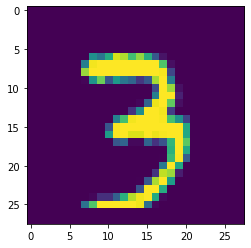

In [ ]:
# mnist_trainset.targets[index] = torch.Tensor(values).type(torch.LongTensor)
j =20078     # Without Shuffle upto True Training numbers correct , after that corrupted
print(plt.imshow(mnist_trainset.data[j]),mnist_trainset.targets[j])

In [ ]:
trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=250,shuffle=True, num_workers=2)

In [ ]:
testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=250,shuffle=False, num_workers=2)

In [ ]:
mnist_trainset.data.shape

torch.Size([47000, 28, 28])

In [ ]:
classes = ('zero', 'one')

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [ ]:
images[:4].shape

torch.Size([4, 1, 28, 28])

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

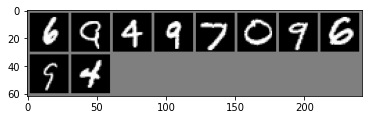

GroundTruth:   zero   one   one   one  zero  zero   one  zero  zero  zero


In [ ]:
imshow(torchvision.utils.make_grid(images[:10]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [ ]:
class Conv_module(nn.Module):
    def __init__(self,inp_ch,f,s,k,pad):
        super(Conv_module,self).__init__()
        self.inp_ch = inp_ch
        self.f = f
        self.s = s 
        self.k = k 
        self.pad = pad
        
        
        self.conv = nn.Conv2d(self.inp_ch,self.f,k,stride=s,padding=self.pad)
        self.bn = nn.BatchNorm2d(self.f)
        self.act = nn.ReLU()
    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [ ]:
class inception_module(nn.Module):
    def __init__(self,inp_ch,f0,f1):
        super(inception_module, self).__init__()
        self.inp_ch = inp_ch
        self.f0 = f0
        self.f1 = f1
        
        
        
        self.conv1 = Conv_module(self.inp_ch,self.f0,1,1,pad=0)
        self.conv3 = Conv_module(self.inp_ch,self.f1,1,3,pad=1)
        #self.conv1 = nn.Conv2d(3,self.f0,1)
        #self.conv3 = nn.Conv2d(3,self.f1,3,padding=1)
    def forward(self,x):
        x1 = self.conv1.forward(x)
        x3 = self.conv3.forward(x)
        #print(x1.shape,x3.shape)
        
        x = torch.cat((x1,x3),dim=1)
        
    
        return x

In [ ]:
class downsample_module(nn.Module):
    def __init__(self,inp_ch,f):
        super(downsample_module,self).__init__()
        self.inp_ch = inp_ch
        self.f = f
        self.conv = Conv_module(self.inp_ch,self.f,2,3,pad=0)
        self.pool = nn.MaxPool2d(3,stride=2,padding=0)
    def forward(self,x):
        x1 = self.conv(x)
        #print(x1.shape)
        x2 = self.pool(x)
        #print(x2.shape)
        x = torch.cat((x1,x2),dim=1)
        
        return x,x1

In [ ]:
class inception_net(nn.Module):
    def __init__(self):
        super(inception_net,self).__init__()
        self.conv1 = Conv_module(1,96,1,3,0)
        
        self.incept1 = inception_module(96,32,32)
        self.incept2 = inception_module(64,32,48)
        
        self.downsample1 = downsample_module(80,80)
        
        self.incept3 = inception_module(160,112,48)
        self.incept4 = inception_module(160,96,64)
        self.incept5 = inception_module(160,80,80)
        self.incept6 = inception_module(160,48,96)
        
        self.downsample2 = downsample_module(144,96)
        
        self.incept7 = inception_module(240,176,60)
        self.incept8 = inception_module(236,176,60)
        
        self.pool = nn.AvgPool2d(5)
        
        
        
        self.linear = nn.Linear(236,2)
    def forward(self,x):
        x = self.conv1.forward(x)
        #act1 = x
        
        x = self.incept1.forward(x)
        #act2 = x
        
        x = self.incept2.forward(x)
        #act3 = x
        
        x,act4 = self.downsample1.forward(x)
        
        x = self.incept3.forward(x)
        #act5 = x
        
        x = self.incept4.forward(x)
        #act6 = x
        
        x = self.incept5.forward(x)
        #act7 = x
        
        x = self.incept6.forward(x)
        #act8 = x
        
        x,act9 = self.downsample2.forward(x)
        
        x = self.incept7.forward(x)
        #act10 = x
        x = self.incept8.forward(x)
        #act11 = x
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = x.view(-1,1*1*236)
        x = self.linear(x) 
        return x

In [ ]:
inc = inception_net()
inc = inc.to("cuda")

In [ ]:
criterion_inception = nn.CrossEntropyLoss()
optimizer_inception = optim.SGD(inc.parameters(), lr=0.01, momentum=0.9)

In [ ]:
acti = []
loss_curi = []
for epoch in range(epochs): # loop over the dataset multiple times
    ep_lossi = []

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to("cuda"),labels.to("cuda")

        # print(inputs.shape)
        # zero the parameter gradients
        optimizer_inception.zero_grad()

        # forward + backward + optimize
        outputs = inc(inputs)
        loss = criterion_inception(outputs, labels)
        loss.backward()
        optimizer_inception.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            ep_lossi.append(running_loss/50) # loss per minibatch
            running_loss = 0.0
            
    loss_curi.append(np.mean(ep_lossi))   #loss per epoch
    if (np.mean(ep_lossi)<=0.03):
        break
#         acti.append(actis)
    
            

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,    50] loss: 0.597
[1,   100] loss: 0.549
[1,   150] loss: 0.537
[2,    50] loss: 0.526
[2,   100] loss: 0.522
[2,   150] loss: 0.513
[3,    50] loss: 0.515
[3,   100] loss: 0.516
[3,   150] loss: 0.523
[4,    50] loss: 0.508
[4,   100] loss: 0.507
[4,   150] loss: 0.512
[5,    50] loss: 0.501
[5,   100] loss: 0.511
[5,   150] loss: 0.506
[6,    50] loss: 0.495
[6,   100] loss: 0.503
[6,   150] loss: 0.505
[7,    50] loss: 0.491
[7,   100] loss: 0.496
[7,   150] loss: 0.498
[8,    50] loss: 0.477
[8,   100] loss: 0.492
[8,   150] loss: 0.497
[9,    50] loss: 0.471
[9,   100] loss: 0.482
[9,   150] loss: 0.488
[10,    50] loss: 0.459
[10,   100] loss: 0.477
[10,   150] loss: 0.481
[11,    50] loss: 0.448
[11,   100] loss: 0.471
[11,   150] loss: 0.477
[12,    50] loss: 0.437
[12,   100] loss: 0.450
[12,   150] loss: 0.460
[13,    50] loss: 0.410
[13,   100] loss: 0.443
[13,   150] loss: 0.454
[14,    50] loss: 0.396
[14,   100] loss: 0.419
[14,   150] loss: 0.435
[15,    50] loss: 0

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to("cuda"), labels.to("cuda")
        outputs = inc(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 60000 train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 60000 train images: 99 %


In [ ]:
total,correct

(47000, 46615)

In [ ]:
correct = 0
total = 0
out = []
pred = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to("cuda"),labels.to("cuda")
        out.append(labels.cpu().numpy())
        outputs= inc(images)
        _, predicted = torch.max(outputs.data, 1)
        pred.append(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 21 %


In [ ]:
out = np.concatenate(out,axis=0)

In [ ]:
pred = np.concatenate(pred,axis=0)

In [ ]:
index = np.logical_or(out ==1,out==0)
print(index.shape)

(10000,)


In [ ]:
acc = sum(out[index] == pred[index])/sum(index)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100*acc))

Accuracy of the network on the 10000 test images: 99 %


In [ ]:

sum(index)

2115

In [ ]:
import random
random.sample([1,2,3,4,5,6,7,8],5)

[1, 5, 6, 8, 7]

In [ ]:
# torch.save(inc.state_dict(),"/content/drive/My Drive/model_simple_8000.pkl")

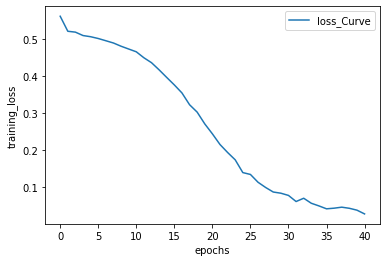

In [ ]:
fig = plt.figure()
plt.plot(loss_curi,label="loss_Curve")
plt.xlabel("epochs")
plt.ylabel("training_loss")
plt.legend()
fig.savefig("loss_curve.pdf") 